In [1]:
from __future__ import absolute_import, division
from __future__ import print_function
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd.scipy.misc import logsumexp
from autograd import grad
from autograd.misc.flatten import flatten
from autograd.misc.optimizers import adam
from numpy import genfromtxt
from math import pi
from operator import add
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
from mpl_toolkits.basemap import Basemap


## Première partie : prédiction de latitude et longitude

In [2]:
#création des données
np.random.seed(1)
my_data = genfromtxt('default_plus_chromatic_features_1059_tracks.txt', delimiter=',')
target = my_data[:,116:]
my_data = np.unique(my_data, axis =1)
my_data = my_data[:,2:]
my_data = np.concatenate((my_data, target), axis = 1)
np.random.shuffle(my_data)
train = my_data[1:900,]
test = my_data[901:,]
np.shape(my_data)

(1059, 74)

### Code

In [3]:
#Distance du Grand Cercle
def dgc(lat_1, lat_2, lon_1, lon_2) :
    #conversion degré -> rad
    lat_1, lat_2, lon_1, lon_2 = (pi/180)* lat_1, (pi/180)*lat_2, (pi/180)*lon_1, (pi/180)*lon_2
    q = np.sin((lat_1-lat_2)/2)**2+np.cos(lat_1)*np.cos(lat_2)*np.sin((lon_1-lon_2)/2)**2
    return(2*6378*np.arcsin(np.sign(q)*np.sqrt(np.abs(q))))

print("distance entre les deux pôles...")
print("...par la distance du grand cercle")
print(dgc(90,-90, 0, 0))
print("... par la formule circonférence = 2 pi R")
print(np.pi*6378)
print("")

print("distance entre deux points de l'équateur diamétralement opposés...")
print("...par la distance du grand cercle")
print(dgc(0,0, 0, 180))
print("... par la formule circonférence = 2 pi R")
print(np.pi*6378)
print("")

print("distance Paris Bogota...")
print("...par la distance du grand cercle")
print(dgc(4.4,48.5, -74, 2.2))
print("... trouvée sur Internet")
print(8633)



distance entre les deux pôles...
...par la distance du grand cercle
20037.0779446
... par la formule circonférence = 2 pi R
20037.0779445957

distance entre deux points de l'équateur diamétralement opposés...
...par la distance du grand cercle
20037.0779446
... par la formule circonférence = 2 pi R
20037.0779445957

distance Paris Bogota...
...par la distance du grand cercle
8636.14950817
... trouvée sur Internet
8633


In [4]:
#Fonction de création des paramètres directement inspirée de l'exemple
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    """Build a list of (weights, biases) tuples, one for each layer."""
    return [(0.1*rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

#Fonction de prédiction directement inspirée de l'exemple
def nn_predict(params, inputs, nonlinearity = np.tanh):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = nonlinearity(outputs)

    outputs = nonlinearity(outputs)
    outputs = np.multiply(np.transpose(np.array([90*np.ones(np.shape(inputs)[0]), 180*np.ones(np.shape(inputs)[0])])), outputs)
    #outputs = np.mod(outputs, np.transpose(np.array([90*np.ones(np.shape(inputs)[0]), 180*np.ones(np.shape(inputs)[0])])))
    return (outputs)


init_scale = 0.01
init_params = init_random_params(init_scale, layer_sizes=[72, 25, 2])


def mean_error (inputs, optimized_params) :
    preds = nn_predict(optimized_params, inputs[:, :72])
    dists = []
    for i in range(np.shape(preds)[0]) : 
        dists = dists + [dgc(preds[i, 0], inputs[i, 72], preds[i, 1], inputs[i, 73])]
    return(np.sum(dists)/np.shape(dists)[0])

#fonction objectif faisant intervenir le grand cercle
def objective(params, t, batch_size=40) :
    #Découpage en minibatch
    #u = début, v = fin
    u = t*batch_size
    u = u%np.shape(train) [0]
    v = (t+1)*batch_size
    v = v%np.shape(train) [0]
    #si on a parcouru la population, on revient au début en mélengeant la population
    if u<v : 
        batch  =list(range(u, v))
    else : 
        batch = list(range(u, np.shape(train)[0]))+list(range(v))
        np.random.shuffle(train)
    
    train_error = mean_error(train[batch] , params)
    test_error = mean_error(test, params)
    print("itération", t)
    print("erreur moyenne", train_error)
    print("erreur test", test_error)
    print('#####')
    return(train_error)

objective(init_params, 1)


itération 1
erreur moyenne 6477.80160416
erreur test 6603.9583195
#####


6477.801604162928

### Résultats

In [5]:
#Optimisation 

optimized_params = adam(grad(objective), init_params, step_size=0.01, num_iters=250)

itération 0
erreur moyenne Autograd ArrayBox with value 6775.16197005
erreur test Autograd ArrayBox with value 6603.9583195
#####
itération 1
erreur moyenne Autograd ArrayBox with value 6311.68668417
erreur test Autograd ArrayBox with value 6440.37583691
#####
itération 2
erreur moyenne Autograd ArrayBox with value 7659.04747754
erreur test Autograd ArrayBox with value 6126.81951867
#####
itération 3
erreur moyenne Autograd ArrayBox with value 6262.06306212
erreur test Autograd ArrayBox with value 5859.62813165
#####
itération 4
erreur moyenne Autograd ArrayBox with value 6410.48418361
erreur test Autograd ArrayBox with value 5642.10505275
#####
itération 5
erreur moyenne Autograd ArrayBox with value 5163.73720522
erreur test Autograd ArrayBox with value 5444.2162157
#####
itération 6
erreur moyenne Autograd ArrayBox with value 5483.77090595
erreur test Autograd ArrayBox with value 5228.7417322
#####
itération 7
erreur moyenne Autograd ArrayBox with value 5446.27005275
erreur test Auto

itération 65
erreur moyenne Autograd ArrayBox with value 3685.56052587
erreur test Autograd ArrayBox with value 3678.38471789
#####
itération 66
erreur moyenne Autograd ArrayBox with value 2971.16611632
erreur test Autograd ArrayBox with value 3615.38932194
#####
itération 67
erreur moyenne Autograd ArrayBox with value 3484.63497644
erreur test Autograd ArrayBox with value 3577.63487584
#####
itération 68
erreur moyenne Autograd ArrayBox with value 3159.73756681
erreur test Autograd ArrayBox with value 3548.949264
#####
itération 69
erreur moyenne Autograd ArrayBox with value 2572.23623178
erreur test Autograd ArrayBox with value 3558.97742537
#####
itération 70
erreur moyenne Autograd ArrayBox with value 3604.91262105
erreur test Autograd ArrayBox with value 3588.63871922
#####
itération 71
erreur moyenne Autograd ArrayBox with value 3952.85087775
erreur test Autograd ArrayBox with value 3633.18935847
#####
itération 72
erreur moyenne Autograd ArrayBox with value 2893.90192705
erreur 

itération 127
erreur moyenne Autograd ArrayBox with value 3388.70487103
erreur test Autograd ArrayBox with value 3637.40217255
#####
itération 128
erreur moyenne Autograd ArrayBox with value 3168.42580161
erreur test Autograd ArrayBox with value 3589.91726192
#####
itération 129
erreur moyenne Autograd ArrayBox with value 3447.38410006
erreur test Autograd ArrayBox with value 3584.63679884
#####
itération 130
erreur moyenne Autograd ArrayBox with value 2890.62205895
erreur test Autograd ArrayBox with value 3544.51721296
#####
itération 131
erreur moyenne Autograd ArrayBox with value 3261.31756529
erreur test Autograd ArrayBox with value 3536.94431665
#####
itération 132
erreur moyenne Autograd ArrayBox with value 2801.74067899
erreur test Autograd ArrayBox with value 3544.72636004
#####
itération 133
erreur moyenne Autograd ArrayBox with value 3266.05868403
erreur test Autograd ArrayBox with value 3560.18818902
#####
itération 134
erreur moyenne Autograd ArrayBox with value 3097.947706

itération 191
erreur moyenne Autograd ArrayBox with value 3034.64301868
erreur test Autograd ArrayBox with value 3422.23758239
#####
itération 192
erreur moyenne Autograd ArrayBox with value 3546.92869553
erreur test Autograd ArrayBox with value 3441.1100155
#####
itération 193
erreur moyenne Autograd ArrayBox with value 2405.96253704
erreur test Autograd ArrayBox with value 3501.8673743
#####
itération 194
erreur moyenne Autograd ArrayBox with value 3297.32301208
erreur test Autograd ArrayBox with value 3579.94375161
#####
itération 195
erreur moyenne Autograd ArrayBox with value 3482.95704031
erreur test Autograd ArrayBox with value 3623.85476714
#####
itération 196
erreur moyenne Autograd ArrayBox with value 3299.73755445
erreur test Autograd ArrayBox with value 3624.46640546
#####
itération 197
erreur moyenne Autograd ArrayBox with value 2808.61589391
erreur test Autograd ArrayBox with value 3612.82567305
#####
itération 198
erreur moyenne Autograd ArrayBox with value 3162.62256068

In [466]:
def gen_color (dist) : 
    return(('c','b','g','y','r','m')[int(6*(dist)/20037)])
    

def plotter(idx) :
    fig=plt.figure(figsize=(18, 16))
    ax=fig.add_axes([0.1,0.1,0.8,0.8])
    m = Basemap(llcrnrlon=-180.,llcrnrlat=-60.,urcrnrlon=180.,urcrnrlat=70.,\
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',projection='merc',\
                lat_0=40.,lon_0=-20.,lat_ts=20.)
    idx = np.where(test.transpose()[73]==np.unique(test.transpose()[73])[idx])[0]
    preds = nn_predict(optimized_params,test[:, :72])
    m.drawcoastlines()
    for i in list(idx): 
        col = gen_color(dgc(preds[i, 0], test[i, 72], preds[i, 1], test[i, 73]))
        m.drawgreatcircle(preds[i, 1],preds[i, 0],test[i, 73],test[i,72],linewidth=2,color=col)
        m.scatter(preds[i, 1],preds[i, 0], s=40, latlon  = True, color = col)

    plt.show()
    
ordre = np.argsort(test.transpose()[72])
test = test[ordre]
preds = nn_predict( optimized_params,test[:,:72])



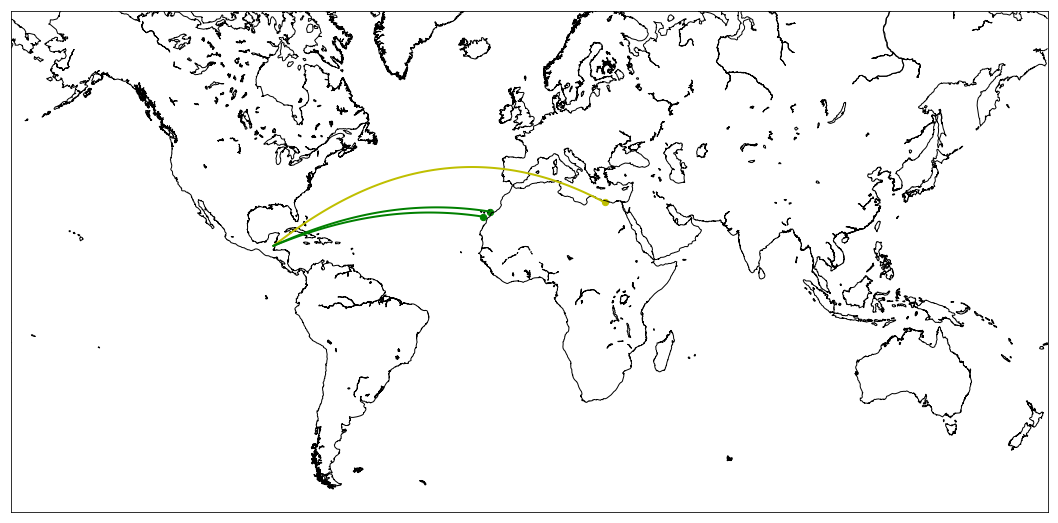

In [467]:
plotter(0)

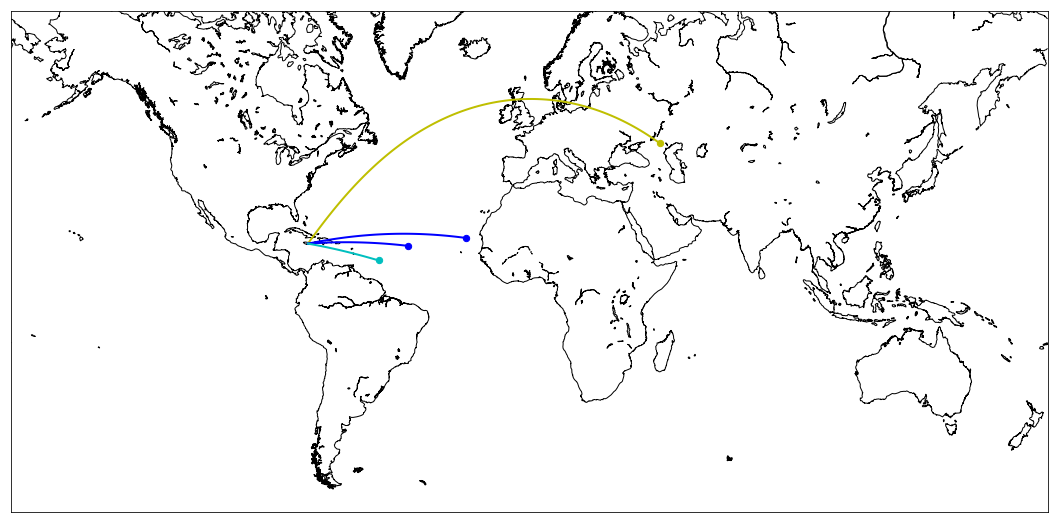

In [468]:
plotter(1)

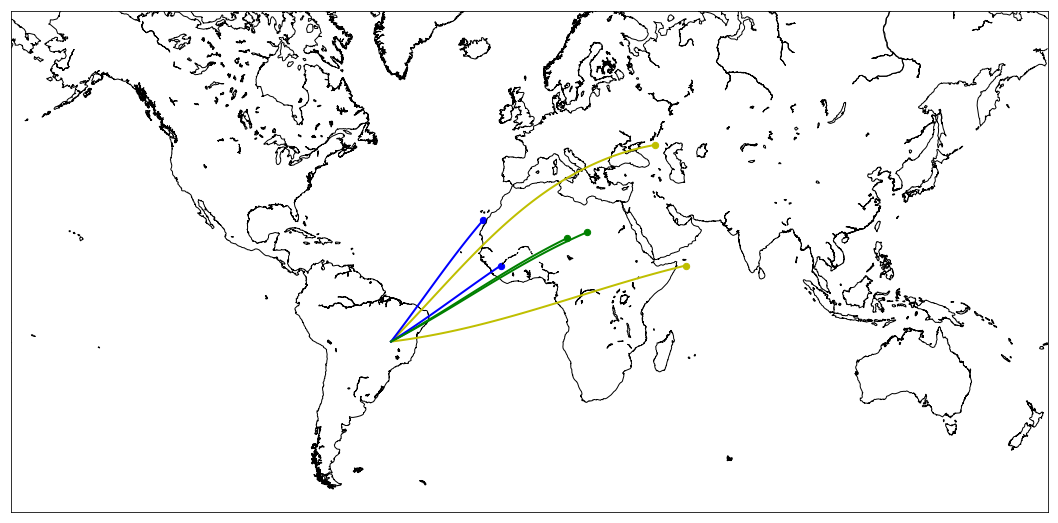

In [469]:
plotter(2)

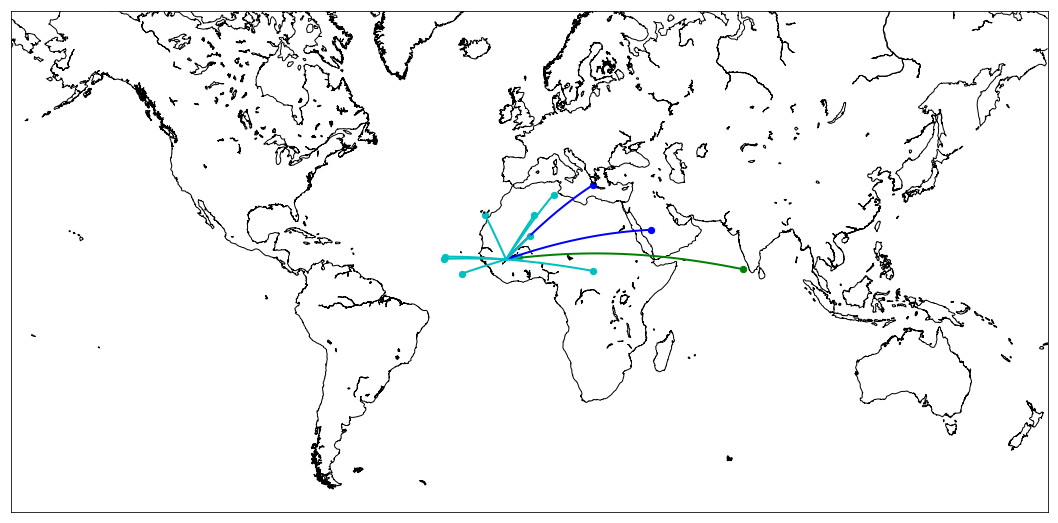

In [471]:
plotter(5)

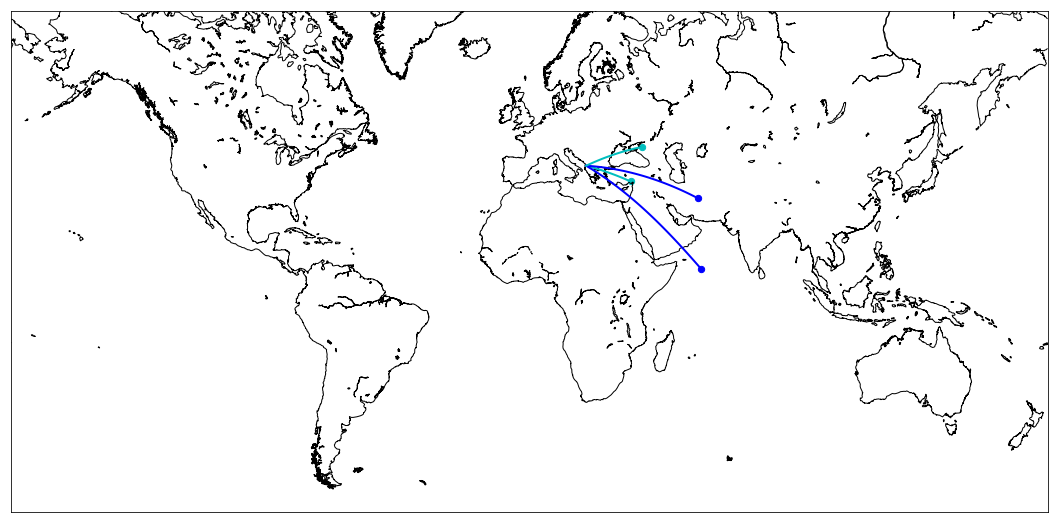

In [475]:
plotter(10)

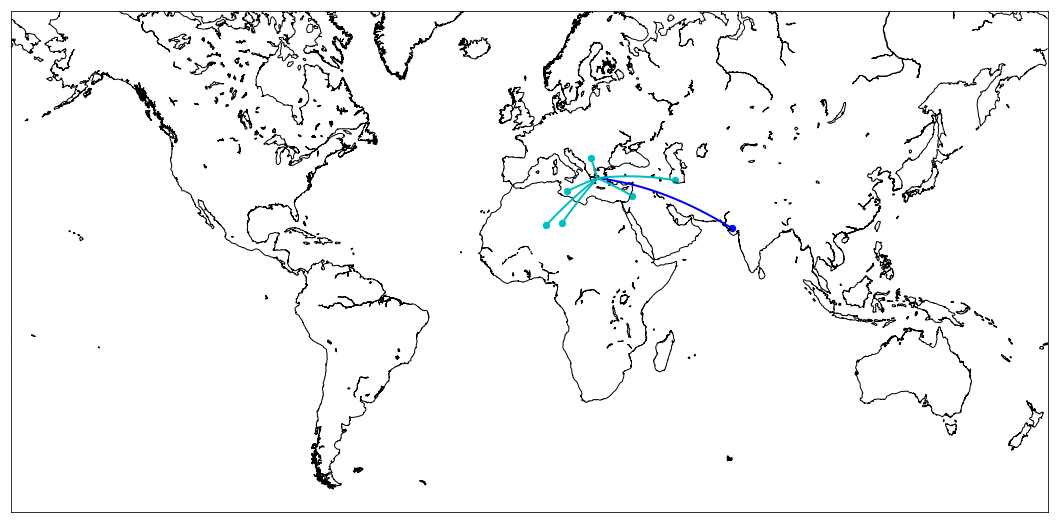

In [476]:
plotter(11)

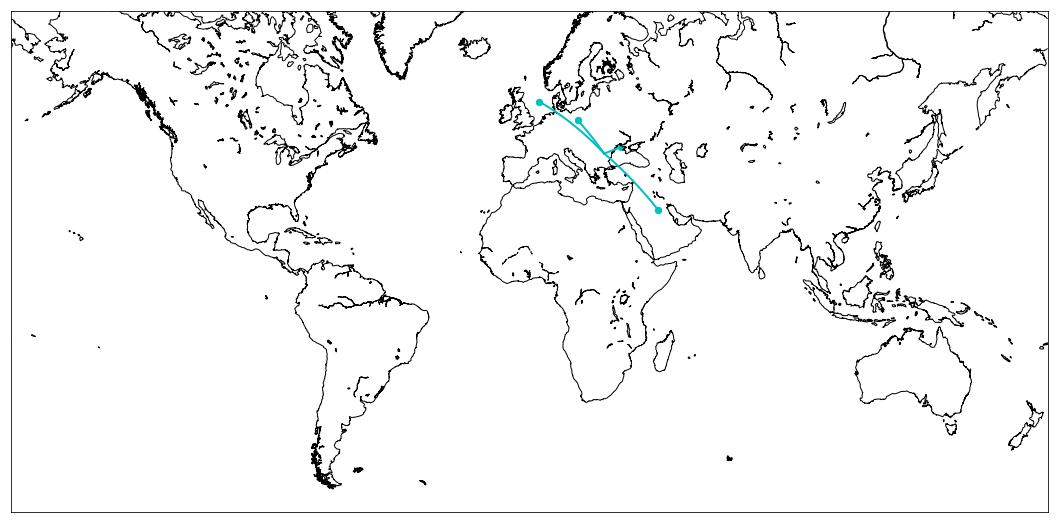

In [477]:
plotter(13)

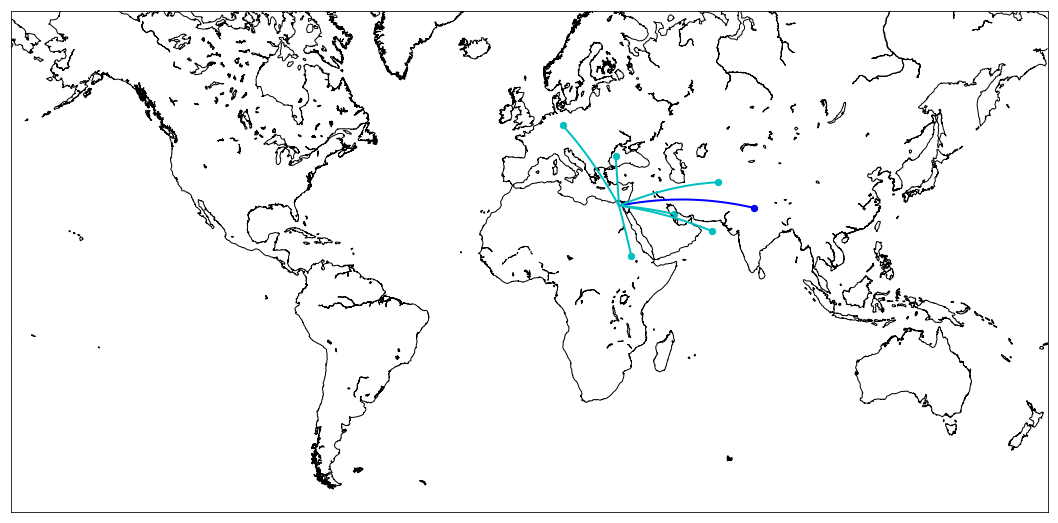

In [478]:
plotter(14)

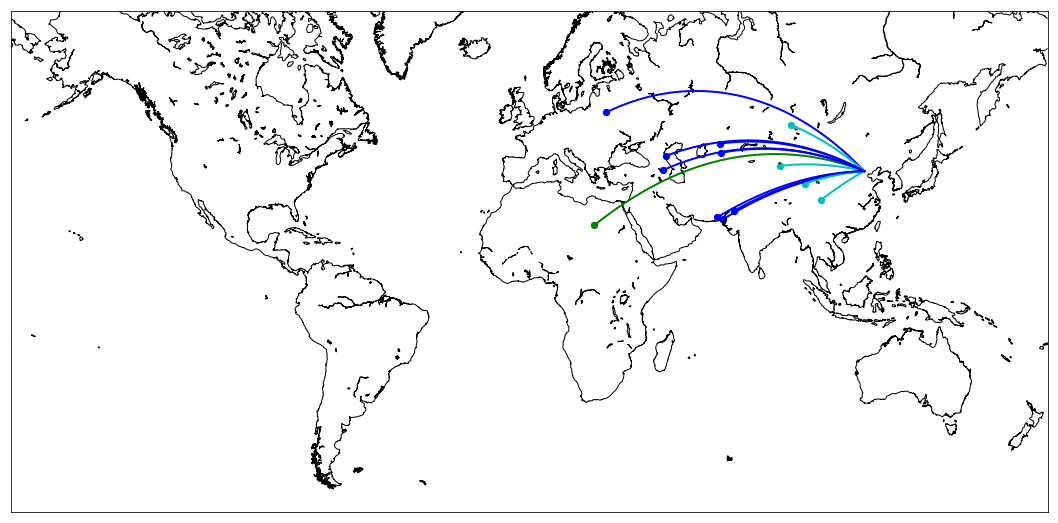

In [479]:
plotter(29)

## Seconde partie : utilisation du heatmap avec Kullback-Leibler

In [6]:
#création des données
heatmap = np.loadtxt('heatmap.txt')
my_data = genfromtxt('default_plus_chromatic_features_1059_tracks.txt', delimiter=',')
my_data = my_data[0:len(my_data), 0:72]
my_data = np.concatenate((my_data, heatmap), 1)
train = my_data[0:799,]
test = my_data[800:,]


### Changements de fonctions

In [7]:
init_scale = 0.1
weight_prior_variance = 10.0
init_params = init_random_params(init_scale, layer_sizes=[72, 500, 400])


#Fonction de prédiction directement inspirée de l'exemple
#différence par rapport à avant : on fait en sorte que les outputs soient bien compris entre 0 et 1 et somment à 1
def nn_predict(params, inputs, nonlinearity = np.tanh):
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = nonlinearity(outputs)
    outputs =( np.tanh(outputs)+1)/2
    outputs = outputs/np.sum(outputs)
    return outputs

# Divergence de Kullback-Leibler : on ajoute un epsilon aux histogrammes pour éviter les divisions par 0
def kullback_leibler(predict, true) : 
    predict = predict +0.00000001
    predict = predict/sum(predict)
    true = true+0.00000001
    true = true/sum(true)
    return(-np.sum(predict*np.log(true/predict)))

#fonction objectif : calcule KL entre la prédiction et la vraie valeur à l'itération t
def kullback_leibler_objective(params, t) : 
    predict = nn_predict(params, train[:,0:72] , nonlinearity=np.tanh)
    true = train[:,72:]
    KL = 0
    for i in range(np.shape(true)[0]) : 
        KL = KL +kullback_leibler(predict[i] , true[i] )
    return(KL)



### Résultats

In [8]:
#Optimisation

optimized_params = adam(grad(kullback_leibler_objective), init_params, step_size=0.01, num_iters=2000)

KeyboardInterrupt: 

In [ ]:
def kullback_leibler_loss (params) : 
    preds = pred(params)
    true = []
    for i in range(np.shape(test)[0]) : 
         true.append(test[i, 72:])
    KL = []
    for i in range(np.shape(test)[0]):
        KL.append(kullback_leibler(preds[i] , true[i]))
    return(KL)

print(np.mean(np.array(kullback_leibler_loss(optimized_params))))

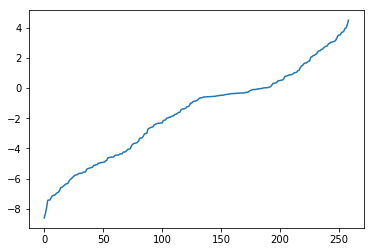

In [49]:
plt.plot(np.sort(np.array(kullback_leibler_loss(optimized_params))-np.array(kullback_leibler_loss(init_params))))
plt.show()

## Troisième partie : utilisation du Heatmap avec earth mover distance

### "Codage" du earth mover distance

In [72]:
#Copier-collé de l'approximation sinkhorn donnée dans le projet


# -*- coding: utf-8 -*-
"""
Dimension reduction with optimal transport
"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

from scipy import linalg
import autograd.numpy as np
from pymanopt.manifolds import Stiefel
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent, TrustRegions


def dist(x1, x2):
    """ Compute squared euclidean distance between samples (autograd)
    """
    x1p2 = np.sum(np.square(x1), 1)
    x2p2 = np.sum(np.square(x2), 1)
    return x1p2.reshape((-1, 1)) + x2p2.reshape((1, -1)) - 2 * np.dot(x1, x2.T)



def sinkhorn(w1, w2, M, reg, k):
    """Sinkhorn algorithm with fixed number of iteration (autograd)
    """
    K = np.exp(-M / reg)
    ui = np.ones((M.shape[0],))
    vi = np.ones((M.shape[1],))
    for i in range(k):
        vi = w2 / (np.dot(K.T, ui))
        ui = w1 / (np.dot(K, vi))
    G = ui.reshape((M.shape[0], 1)) * K * vi.reshape((1, M.shape[1]))
    return G



def split_classes(X, y):
    """split samples in X by classes in y
    """
    lstsclass = np.unique(y)
    return [X[y == i, :].astype(np.float32) for i in lstsclass]



def fda(X, y, p=2, reg=1e-16):
    """
    Fisher Discriminant Analysis


    Parameters
    ----------
    X : numpy.ndarray (n,d)
        Training samples
    y : np.ndarray (n,)
        labels for training samples
    p : int, optional
        size of dimensionnality reduction
    reg : float, optional
        Regularization term >0 (ridge regularization)


    Returns
    -------
    P : (d x p) ndarray
        Optimal transportation matrix for the given parameters
    proj : fun
        projection function including mean centering


    """

    mx = np.mean(X)
    X -= mx.reshape((1, -1))

    # data split between classes
    d = X.shape[1]
    xc = split_classes(X, y)
    nc = len(xc)

    p = min(nc - 1, p)

    Cw = 0
    for x in xc:
        Cw += np.cov(x, rowvar=False)
    Cw /= nc

    mxc = np.zeros((d, nc))

    for i in range(nc):
        mxc[:, i] = np.mean(xc[i])

    mx0 = np.mean(mxc, 1)
    Cb = 0
    for i in range(nc):
        Cb += (mxc[:, i] - mx0).reshape((-1, 1)) * \
            (mxc[:, i] - mx0).reshape((1, -1))

    w, V = linalg.eig(Cb, Cw + reg * np.eye(d))

    idx = np.argsort(w.real)

    Popt = V[:, idx[-p:]]

    def proj(X):
        return (X - mx.reshape((1, -1))).dot(Popt)

    return Popt, proj



def wda(X, y, p=2, reg=1, k=10, solver=None, maxiter=100, verbose=0, P0=None):
    """
    Wasserstein Discriminant Analysis [11]_

    The function solves the following optimization problem:

    .. math::
        P = \\text{arg}\min_P \\frac{\\sum_i W(PX^i,PX^i)}{\\sum_{i,j\\neq i} W(PX^i,PX^j)}

    where :

    - :math:`P` is a linear projection operator in the Stiefel(p,d) manifold
    - :math:`W` is entropic regularized Wasserstein distances
    - :math:`X^i` are samples in the dataset corresponding to class i

    Parameters
    ----------
    X : numpy.ndarray (n,d)
        Training samples
    y : np.ndarray (n,)
        labels for training samples
    p : int, optional
        size of dimensionnality reduction
    reg : float, optional
        Regularization term >0 (entropic regularization)
    solver : str, optional
        None for steepest decsent or 'TrustRegions' for trust regions algorithm
        else shoudl be a pymanopt.solvers
    P0 : numpy.ndarray (d,p)
        Initial starting point for projection
    verbose : int, optional
        Print information along iterations



    Returns
    -------
    P : (d x p) ndarray
        Optimal transportation matrix for the given parameters
    proj : fun
        projection function including mean centering


    References
    ----------

    .. [11] Flamary, R., Cuturi, M., Courty, N., & Rakotomamonjy, A. (2016). Wasserstein Discriminant Analysis. arXiv preprint arXiv:1608.08063.

    """  # noqa

    mx = np.mean(X)
    X -= mx.reshape((1, -1))

    # data split between classes
    d = X.shape[1]
    xc = split_classes(X, y)
    # compute uniform weighs
    wc = [np.ones((x.shape[0]), dtype=np.float32) / x.shape[0] for x in xc]

    def cost(P):
        # wda loss
        loss_b = 0
        loss_w = 0

        for i, xi in enumerate(xc):
            xi = np.dot(xi, P)
            for j, xj in enumerate(xc[i:]):
                xj = np.dot(xj, P)
                M = dist(xi, xj)
                G = sinkhorn(wc[i], wc[j + i], M, reg, k)
                if j == 0:
                    loss_w += np.sum(G * M)
                else:
                    loss_b += np.sum(G * M)

        # loss inversed because minimization
        return loss_w / loss_b

    # declare manifold and problem
    manifold = Stiefel(d, p)
    problem = Problem(manifold=manifold, cost=cost)

    # declare solver and solve
    if solver is None:
        solver = SteepestDescent(maxiter=maxiter, logverbosity=verbose)
    elif solver in ['tr', 'TrustRegions']:
        solver = TrustRegions(maxiter=maxiter, logverbosity=verbose)

    Popt = solver.solve(problem, x=P0)

    def proj(X):
        return (X - mx.reshape((1, -1))).dot(Popt)

    return Popt, proj

In [91]:
#Perte earth mover approximée
#On utilise comme coûts une matrice de 1 avec la diagonale à 0

def earth_mover_objective (params,t) : 
    t = t%799
    predict = nn_predict(params, train[t,0:72] , nonlinearity=np.tanh)
    true = train[t,72:]/sum(train[t,72:])
    M= np.ones((400, 400))-np.identity(400)
    return(np.sum(np.multiply(M,sinkhorn(true, predict, M, 0.05, 1000))))


### Résultats

In [103]:
optimized_params = adam(grad(earth_mover_objective), init_params, step_size=0.01, num_iters=25000)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:88: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)


In [106]:
def earth_mover_loss (params) : 
    preds = pred(params)
    true = []
    for i in range(np.shape(test)[0]) : 
         true.append(test[i, 72:])
    EM = []
    M= np.ones((400, 400))-np.identity(400)
    for i in range(np.shape(test)[0]):
        EM.append(np.sum(np.multiply(sinkhorn( true[i], preds[i], M, 0.05, 1000), M)))
    return(EM)


KeyboardInterrupt: 

In [ ]:
print(np.mean(np.array(earth_mover_loss(optimized_params))))
print(np.mean(np.array(earth_mover_loss(optimized_params))-np.array(earth_mover_loss(init_params))))

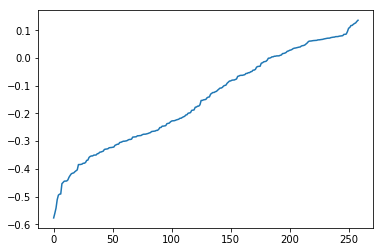

In [105]:
plt.plot(np.sort(np.array(earth_mover_loss(optimized_params))-np.array(earth_mover_loss(init_params))))
plt.show()